In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(set("".join(words)))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c, i  in ctoi.items()}

In [51]:
block_size = 3
X, Y = [], []

for word in words:
    context = [0]* block_size
    # print(word)
    for ch in word+'.':
        idx = ctoi[ch]
        X.append(context)
        Y.append(idx)
        context = context[1:] + [idx]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [54]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = ctoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [55]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [56]:
# create embedding
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((27,2), generator=gen)    # random values

In [57]:
Cntx[torch.tensor([5,7,7])].shape

torch.Size([3, 2])

In [58]:
Cntx[X].shape

torch.Size([228146, 3, 2])

In [59]:
Cntx[X][10,2]

tensor([-1.0725,  0.7276])

In [60]:
X[10,2]

tensor(15)

In [62]:
Cntx[15]

tensor([-1.0725,  0.7276])

In [63]:
embd = Cntx[X]
embd.shape

torch.Size([228146, 3, 2])

In [64]:
W = torch.randn((6, 100), generator=gen) 
B = torch.randn(100, generator=gen)

In [67]:
embd[:,1, :].shape

torch.Size([228146, 2])

In [83]:
torch.concat([embd[:,0, :], embd[:,1, :], embd[:,2, :]], 1).shape

torch.Size([228146, 6])

In [84]:
torch.unbind(embd,1)

(tensor([[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         ...,
         [-1.0725,  0.7276],
         [-0.1158, -1.2078],
         [-0.0274, -1.1008]]),
 tensor([[ 1.5674, -0.2373],
         [ 1.5674, -0.2373],
         [-1.4904, -0.2838],
         ...,
         [-0.1158, -1.2078],
         [-0.0274, -1.1008],
         [-1.2199,  0.3031]]),
 tensor([[ 1.5674, -0.2373],
         [-1.4904, -0.2838],
         [ 0.8480,  2.0275],
         ...,
         [-0.0274, -1.1008],
         [-1.2199,  0.3031],
         [ 0.6772, -0.8404]]))

In [85]:
torch.concat(torch.unbind(embd,1),1)

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.4904, -0.2838],
        [ 1.5674, -0.2373, -1.4904, -0.2838,  0.8480,  2.0275],
        ...,
        [-1.0725,  0.7276, -0.1158, -1.2078, -0.0274, -1.1008],
        [-0.1158, -1.2078, -0.0274, -1.1008, -1.2199,  0.3031],
        [-0.0274, -1.1008, -1.2199,  0.3031,  0.6772, -0.8404]])

In [86]:
embd.view(-1,6)

tensor([[ 1.5674, -0.2373,  1.5674, -0.2373,  1.5674, -0.2373],
        [ 1.5674, -0.2373,  1.5674, -0.2373, -1.4904, -0.2838],
        [ 1.5674, -0.2373, -1.4904, -0.2838,  0.8480,  2.0275],
        ...,
        [-1.0725,  0.7276, -0.1158, -1.2078, -0.0274, -1.1008],
        [-0.1158, -1.2078, -0.0274, -1.1008, -1.2199,  0.3031],
        [-0.0274, -1.1008, -1.2199,  0.3031,  0.6772, -0.8404]])

In [98]:
h = embd.view(-1,6) @ W + B   
h = torch.tanh(h)   # activation
h.shape

torch.Size([228146, 100])

In [99]:
 # final layer
W2 = torch.randn((100, 27), generator=gen)
B2 = torch.randn((27), generator=gen)

In [100]:
logits = h @ W2 + B2
logits.shape

torch.Size([228146, 27])

In [101]:
# softmax
logits = logits.exp()
probs = logits / logits.sum(dim=1, keepdim=True)

In [104]:
# loss computation
loss = 0
n = 0
for i in range(len(Y)):
    p = probs[i, Y[i]]
    log_p = torch.log(p)
    nll = -log_p
    loss += nll
    n += 1
    
avg_nll = loss /n
avg_nll

tensor(15.9541)

In [105]:
loss=-probs[torch.arange(len(Y)), Y].log().mean()
loss

tensor(15.9540)

## Forward pass

In [106]:
# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((27,2), generator=gen)   
W1 = torch.randn((6, 100), generator=gen) 
B1 = torch.randn(100, generator=gen)
W2 = torch.randn((100, 27), generator=gen)
B2 = torch.randn((27), generator=gen)

parameters = [Cntx, W1, B1, W2, B2]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

number of parameters : 3481


In [107]:
for p in parameters:
    p.requires_grad = True

In [114]:
# Forward
embd = Cntx[X]
h1 = torch.tanh((embd.view(-1, 6) @ W1) + B1)
logits = (h1 @ W2) + B2

# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(19.5052, grad_fn=<NllLossBackward0>)

In [115]:
# cross-entropy
F.cross_entropy(logits, Y)

# Above method uses new tensors in memory during loss calculation and cross-entropy doesn't
# backward pass is more efficient


tensor(19.5052, grad_fn=<NllLossBackward0>)

## Backward pass

In [116]:
for p in parameters:
    p.grad = None
    
loss.backward()

# update parameters
for p in parameters:
    p.data += -0.1 * p.grad

## Training

In [117]:
for _ in range(100):
    embd = Cntx[X]
    h1 = torch.tanh((embd.view(-1, 6) @ W1) + B1)
    logits = (h1 @ W2) + B2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad

17.08448028564453
15.776532173156738
14.833343505859375
14.002607345581055
13.253264427185059
12.579920768737793
11.983102798461914
11.47049331665039
11.051857948303223
10.709587097167969
10.407632827758789
10.127808570861816
9.86436653137207
9.614501953125
9.376439094543457
9.148944854736328
8.931109428405762
8.722230911254883
8.521749496459961
8.329227447509766
8.144326210021973
7.966791152954102
7.796450614929199
7.633185386657715
7.476907730102539
7.327520847320557
7.1848859786987305
7.048791885375977
6.918952465057373
6.795018672943115
6.6766037940979
6.563319206237793
6.4547905921936035
6.350669860839844
6.250644683837891
6.154433250427246
6.061786651611328
5.9724836349487305
5.88632869720459
5.8031487464904785
5.722784996032715
5.645096302032471
5.569946765899658
5.497215270996094
5.426782131195068
5.358537197113037
5.29237699508667
5.22820520401001
5.165929794311523
5.105469226837158
5.046749591827393
4.989700794219971
4.934263229370117
4.880382061004639
4.828007698059082
4.777

## Finding proper learning rate

In [118]:
# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((27,2), generator=gen)   
W1 = torch.randn((6, 100), generator=gen) 
B1 = torch.randn(100, generator=gen)
W2 = torch.randn((100, 27), generator=gen)
B2 = torch.randn((27), generator=gen)

parameters = [Cntx, W1, B1, W2, B2]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

number of parameters : 3481


In [119]:
for p in parameters:
    p.requires_grad = True

In [120]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [121]:
lri = []
lossi = []

for i in range(1000):
    
    idx = torch.randint(0, X.shape[0], (32,))
    
    embd = Cntx[X][idx]
    h1 = torch.tanh((embd.view(-1, 6) @ W1) + B1)
    logits = (h1 @ W2) + B2
    loss = F.cross_entropy(logits, Y[idx])
    print(loss.item())
    
    for p in parameters:
        p.grad = None
        
    loss.backward()

    lr = lrs[i]
    
    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    # track
    lri.append(lre[i])
    lossi.append(loss.item())
    

19.57980728149414
19.740999221801758
17.632286071777344
19.124616622924805
18.151325225830078
18.36225700378418
18.950063705444336
19.143417358398438
17.61908531188965
18.067983627319336
17.374387741088867
17.262405395507812
20.171588897705078
18.5577449798584
17.929977416992188
18.8804874420166
18.802892684936523
18.776939392089844
18.700864791870117
18.381942749023438
19.737693786621094
18.473024368286133
17.529441833496094
17.303924560546875
19.687538146972656
17.139694213867188
17.651958465576172
15.263470649719238
20.514179229736328
18.75255012512207
18.811166763305664
16.157899856567383
17.657258987426758
15.66523551940918
14.59780502319336
15.51105785369873
18.25421142578125
18.52699089050293
21.948312759399414
17.519929885864258
15.2411470413208
17.032302856445312
18.863027572631836
19.211402893066406
18.167741775512695
17.725826263427734
19.55362892150879
15.652125358581543
17.760929107666016
16.29831886291504
16.862855911254883
19.615327835083008
18.89130401611328
18.63749885

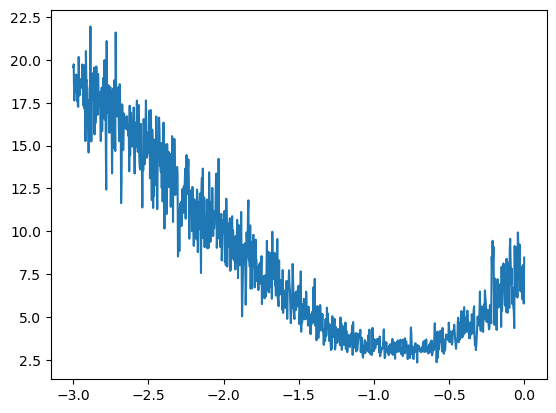

In [122]:
plt.plot(lri,lossi)

In [35]:
# lr = 0.1 would be ideal

## Training with mini batches

In [123]:
# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((27,2), generator=gen)   
W1 = torch.randn((6, 300), generator=gen) 
B1 = torch.randn(300, generator=gen)
W2 = torch.randn((300, 27), generator=gen)
B2 = torch.randn((27), generator=gen)

parameters = [Cntx, W1, B1, W2, B2]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

number of parameters : 10281


In [124]:
for p in parameters:
    p.requires_grad = True

In [127]:
lossi = []
stepi = []

for i in range(100):
    
    idx = torch.randint(0, Xtr.shape[0], (32,))
    
    embd = Cntx[Xtr][idx]
    h1 = torch.tanh((embd.view(-1, 6) @ W1) + B1)
    logits = (h1 @ W2) + B2
    loss = F.cross_entropy(logits, Ytr[idx])
    # print(loss.item())
    
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad
        
    stepi.append(i)
    lossi.append(loss.item())
    
print(loss.item())

3.5253067016601562


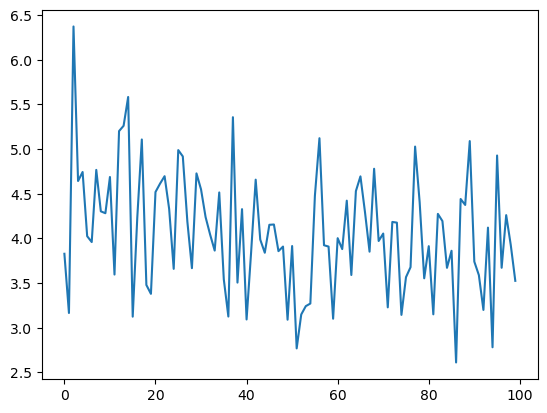

In [128]:
plt.plot(stepi,lossi)

In [40]:
embd = Cntx[Xdev]
h1 = torch.tanh((embd.view(-1, 6) @ W1) + B1)
logits = (h1 @ W2) + B2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

4.661213397979736


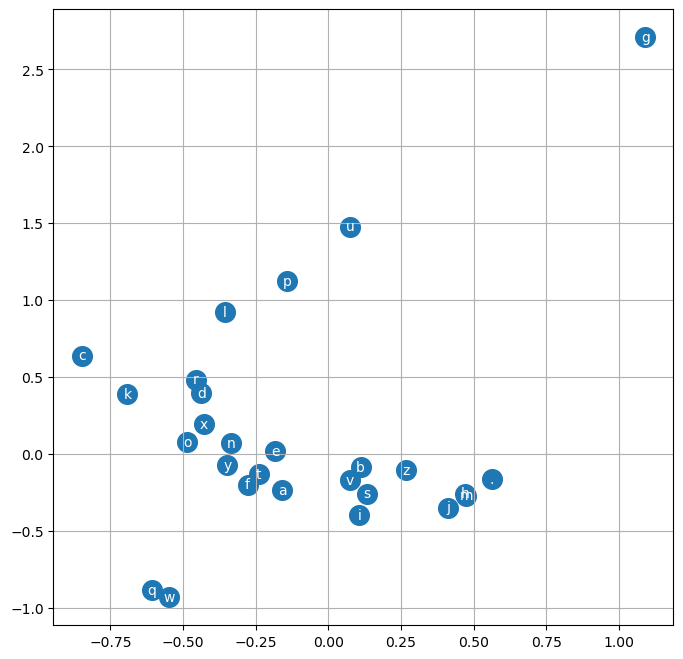

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(Cntx[:,0].data, Cntx[:,1].data, s=200)
for i in range(Cntx.shape[0]):
    plt.text(Cntx[i,0].item(), Cntx[i,1].item(), itoc[i], ha="center", va="center", color="white")
plt.grid("minor")

## increase embedding size

In [129]:
# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((27,10), generator=gen)   
W1 = torch.randn((30, 200), generator=gen) 
B1 = torch.randn(200, generator=gen)
W2 = torch.randn((200, 27), generator=gen)
B2 = torch.randn((27), generator=gen)

parameters = [Cntx, W1, B1, W2, B2]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 11897


In [130]:
lossi = []
stepi = []

In [131]:
for i in range(1000):
    
    idx = torch.randint(0, Xtr.shape[0], (32,))
    
    embd = Cntx[Xtr][idx]
    h1 = torch.tanh((embd.view(-1, 30) @ W1) + B1)
    logits = (h1 @ W2) + B2
    loss = F.cross_entropy(logits, Ytr[idx])
    # print(loss.item())
    
    for p in parameters:
        p.grad = None
        
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad
        
    stepi.append(i)
    lossi.append(loss.log10().item())
    
print(loss.item())

3.835416078567505


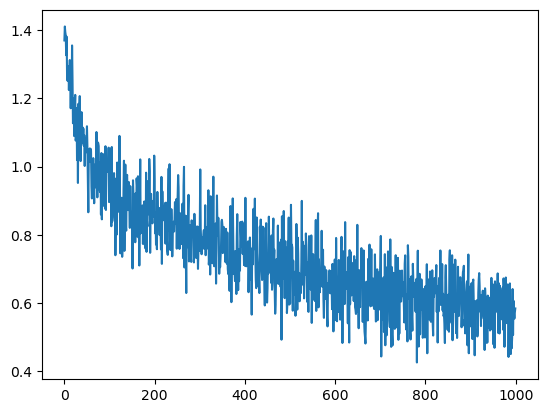

In [132]:
plt.plot(stepi,lossi)

In [133]:
embd = Cntx[Xdev]
h1 = torch.tanh((embd.view(-1, 30) @ W1) + B1)
logits = (h1 @ W2) + B2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

3.8710291385650635


## sample

In [134]:
gen = torch.Generator().manual_seed(2147483647)

for i in range(12):
    out = []
    context = [0] * block_size
    
    while True:
        
        # prob = normalised_counts_tensor[ix]
        
        embd = Cntx[torch.tensor([context])]
        h1 = torch.tanh((embd.view(1, -1) @ W1) + B1)
        logits = (h1 @ W2) + B2             
        prob = F.softmax(logits, dim=1)
        ix = torch.multinomial(prob, num_samples=1, generator=gen).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itoc[j] for j in out))

junn.
mailiani.
jaxcvwadi.
nir.
jiinttonion.
jann.
koysi.
aui.
mille.
ajeta.
anima.
millse.
